## Playlist x Unique Songs Sparse Matrix

For further model building, it will be helpful to have a sparse matrix that encodes our playlists in rows and our unique songs in columns. A one (1) in a particular cell of the matrix means that playlist has that song. A zero (0) means it doesn't. We need to carefully look at sparsity here - a matrix that is too sparse means that using matrix factorization to learn latent variables wouldn't work very well because there aren't enough playlist/song interactions. How much of an impact this has is something that I would like to test by creating matrices of varying sparsity through filtering out playlists with few songs or songs rarely featured. 

references: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/, https://jessesw.com/Rec-System/

In [1]:
#load libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
import random
import itertools
import copy

In [2]:
con = sqlite3.connect("/Users/jamillaakhund-zade/CS109A/Spotify_Project/data/mpd.db")

In [3]:
#calculate sparsity as 100 - (actual num of playlist-song interactions/all possible playlist-song interactions)

n_pls = 1000000 #we know we have 1 million playlists - it's the name of the dataset!

cur = con.cursor()
cur.execute('SELECT MAX(track_id) FROM songs')
n_songs = cur.fetchone()[0] #query songs table for num unique songs

cur = con.cursor()
cur.execute('SELECT MAX(id) FROM mpd') 
mpd_shape = cur.fetchone()[0] #get num of playlist x track interactions

#calculate matrix sparsity
print(f'Num playlists: {n_pls}')
print(f'Num unique songs: {n_songs}')
print(f'Sparsity: {100 - float(mpd_shape)/float(n_pls*n_songs) * 100:0.3f}%')


Num playlists: 1000000
Num unique songs: 2262292
Sparsity: 99.997%


This is very high sparsity! It might be too low for us to make matrix factorization models work. We should try filtering out songs that appear less than N (N is our choice) times across the whole dataset and playlists with too few songs. This might serve to make our matrix more dense. We should be aiming for a sparsity of 99.5% and below (https://jessesw.com/Rec-System/)

Out of curiosity, I would like to make a sparse matrix out of the unfiltered data in order to test just how much the matrix factorization model will be impacted by including these short playlists/rare songs. 

In [4]:
mpd = pd.read_sql('SELECT pid, track_id FROM mpd', con)
print(mpd.shape)
mpd.head()

(66346428, 2)


,pid,track_id
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


In [28]:
#make sparse matrix
cols = mpd.pid.astype('category').cat.codes # make category codes/indices for each playlist
rows = mpd.track_id.astype('category').cat.codes # make category codes/indices for each song
likes = np.ones(mpd.shape[0]) #1s if song is in playlist

In [29]:
songs_mat = sparse.csr_matrix((likes, (rows, cols)), dtype=np.float64) #make sparse matrix
#print(songs.groupby(by=['pid']).count()['track_id'])

In [31]:
songs_mat

#fewer elements in matrix than number of records - this is because duplicate songs in the same playlist are lumped into the same cell - if a song is featured twice in the same playlist, that playlist x song interaction cell will now be 2 instead of 1. This makes up ~ 1.4% of all our cases, and could be an important signal of how some playlists are structured, so I will keep the duplicate interactions. 

<2262292x1000000 sparse matrix of type '<class 'numpy.float64'>'
	with 65464776 stored elements in Compressed Sparse Row format>

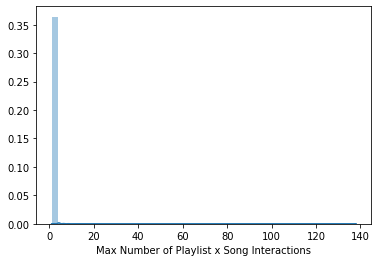

In [54]:
maxs = songs_mat.max(1).toarray() #max number of playlist x song interactions evaluted on matrix rows
ax = sns.distplot(maxs)
ax.set_xlabel('Max Number of Playlist x Song Interactions');

In [14]:
songs_mat.getcol(10)

<961x1 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [32]:
sparse.save_npz('/Users/jamillaakhund-zade/CS109A/Spotify_Project/data/full_item_user_matrix.npz', songs_mat)

In [58]:
con.close()

In [59]:
def threshold_data_sqlite(path, min_pid_length, min_track_cts):
    '''
    drops all playlists with length less than min_pid_length and all tracks featured 
    less than min_track_cts in the data. Does so iteratively until data size remains stable.
    Inspired by code from https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
  
    uses sqlite commands to do filtering and dropping within the database
    '''
    #connect to sqlite database
    con = sqlite3.connect(path)
    #establish cursor
    cur = con.cursor()

    done = False
    while not done:
        #starting num rows dropped
        start_rows_dropped = con.total_changes #num rows inserted/deleted/modified since database opened

        #filter playlists
        cur.execute('DELETE FROM mpd WHERE pid IN \
                    (SELECT pid \
                    FROM mpd \
                    GROUP BY pid \
                    HAVING COUNT(track_id) < (?))', (min_pid_length,))

        #filter songs
        cur.execute('DELETE FROM mpd WHERE track_id IN \
                    (SELECT track_id \
                    FROM mpd \
                    GROUP BY track_id \
                    HAVING COUNT(pid) < (?))', (min_track_cts,))

        #ending num rows dropped
        end_rows_dropped = con.total_changes

        #break out of while loop if no more rows filtered out
        if start_rows_dropped == end_rows_dropped:
            done = True
    
    #grab dataframe from filtered table
    cur.execute('SELECT pid, track_id FROM mpd')
    df = pd.DataFrame(cur.fetchall(), columns = ['pid', 'track_id'])

    con.close() #close connection

    #calculate sparsity of new table
    n_pls = df.pid.unique().shape[0]
    n_songs = df.track_id.unique().shape[0]

    #calculate new matrix sparsity
    print(f'Num playlists: {n_pls}')
    print(f'Num unique songs: {n_songs}')
    print(f'Sparsity: {100 - float(df.shape[0]) /float(n_pls*n_songs) * 100:0.5f}%')

    return df    

In [60]:
path = "/Users/jamillaakhund-zade/CS109A/Spotify_Project/data/mpd.db"
thresh_df = threshold_data_sqlite(path, 50, 50)

Num playlists: 410606
Num unique songs: 84812
Sparsity: 99.88253%


In [64]:
#make sparse matrix
cols = thresh_df.pid.astype('category').cat.codes # make category codes/indices for each playlist
rows = thresh_df.track_id.astype('category').cat.codes # make category codes/indices for each song
likes = np.ones(thresh_df.shape[0]) #1s if song is in playlist

In [65]:
thresh_songs_mat = sparse.csr_matrix((likes, (rows, cols)), dtype=np.float64) #make sparse matrix
thresh_songs_mat

<84812x410606 sparse matrix of type '<class 'numpy.float64'>'
	with 40295393 stored elements in Compressed Sparse Row format>

In [66]:
sparse.save_npz('/Users/jamillaakhund-zade/CS109A/Spotify_Project/data/thresh50_item_user_matrix.npz', songs_mat)

In [61]:
print(thresh_df['pid'].value_counts().min())
print(thresh_df['track_id'].value_counts().min())

50
50


In [ ]:
def threshold_data(songs, min_pid_length, min_track_cts):
  '''drops all playlists with length less than min_pid_length and all tracks featured 
  less than min_track_cts in the data. Does so iteratively until data size remains stable.
  Inspired by code from https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/'''

  done = False
  while not done:
    starting_shape = songs.shape[0] #print starting num rows
    #filter playlists
    pid_cts = songs['pidfile_name'].value_counts()
    drop_idx = songs.loc[songs.pidfile_name.isin(pid_cts[pid_cts < min_pid_length].index)].index
    songs.drop(drop_idx, inplace = True)
    #filter songs
    track_cts = songs['track_uri'].value_counts()
    drop_idx = songs.loc[songs.track_uri.isin(track_cts[track_cts < min_track_cts].index)].index
    songs.drop(drop_idx, inplace = True)
    #print ending num rows
    ending_shape = songs.shape[0]
    #break out of while loop if no more rows filtered out
    if starting_shape == ending_shape:
      done = True

  n_pls = songs.pidfile_name.unique().shape[0]
  n_songs = songs.track_uri.unique().shape[0]

  #calculate new matrix sparsity
  print(f'Num playlists: {n_pls}')
  print(f'Num unique songs: {n_songs}')
  print(f'Sparsity: {100 - float(songs.shape[0]) /float(n_pls*n_songs) * 100:0.5f}%')
